<center>

# What's Cooking Challenge

### <i> Progetto per l'esame di Programmazione di applicazioni di Data Intensive (2019) </i>

### Cichetti Federico, Sponziello Nicolò
</center>

Il progetto ha lo scopo di creare un modello in grado di classificare il tipo di cucina di una ricetta in base agli ingredienti forniti.

## Librerie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import pickle
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC

%matplotlib inline

nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Volpe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Volpe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Volpe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Esplorazione dei dati

Partiamo caricando i dati in un dataframe Pandas e visualizzandone una parte per capire come sono strutturati

In [2]:
df = pd.read_json("train.json")
pd.options.display.max_colwidth = 500

In [3]:
df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]"
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]"
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]"
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam masala, double cream, natural yogurt, bay leaf]"


In [4]:
df.tail()

,cuisine,id,ingredients
39769,irish,29109,"[light brown sugar, granulated sugar, butter, warm water, large eggs, all-purpose flour, whole wheat flour, cooking spray, boiling water, steel-cut oats, dry yeast, salt]"
39770,italian,11462,"[KRAFT Zesty Italian Dressing, purple onion, broccoli florets, rotini, pitted black olives, Kraft Grated Parmesan Cheese, red pepper]"
39771,irish,2238,"[eggs, citrus fruit, raisins, sourdough starter, flour, hot tea, sugar, ground nutmeg, salt, ground cinnamon, milk, butter]"
39772,chinese,41882,"[boneless chicken skinless thigh, minced garlic, steamed white rice, baking powder, corn starch, dark soy sauce, kosher salt, peanuts, flour, scallions, Chinese rice vinegar, vodka, fresh ginger, egg whites, broccoli, toasted sesame seeds, sugar, store bought low sodium chicken stock, baking soda, Shaoxing wine, oil]"
39773,mexican,2362,"[green chile, jalapeno chilies, onions, ground black pepper, salt, chopped cilantro fresh, green bell pepper, garlic, white sugar, roma tomatoes, celery, dried oregano]"


Il dataframe ha tre colonne:
- "cuisine" indica il tipo di cucina a cui appartiene il piatto. Questa sarà l'incognita da scoprire.
- "id" è una colonna che contiene un numero identificativo di ogni piatto. Questo dato non è utile al problema, quindi decidiamo di eliminare la colonna e usare come identificativo l'indice aggiunto in automatico da Pandas.
- "ingredients" contiene la lista di ingredienti del piatto.

In [5]:
if "id" in df:
    df.drop("id", inplace=True, axis=1)
df.head()

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]"
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]"
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]"
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam masala, double cream, natural yogurt, bay leaf]"


Prima di procedere si esplorano e visualizzano alcuni dati, in particolare:
* Quante ricette sono presenti
* La totalità degli ingredienti

In [6]:
len(df)

39774

Le ricette da classificare nel dataset sono 39774 in totale.

In [7]:
len(df['cuisine'].unique())

20

In totale ci sono 20 tipi di cucine differenti. Si tratta quindi di un problema di classificazione multiclasse.
Controlliamo quanti piatti ci sono per ogni cucina.

In [8]:
df['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

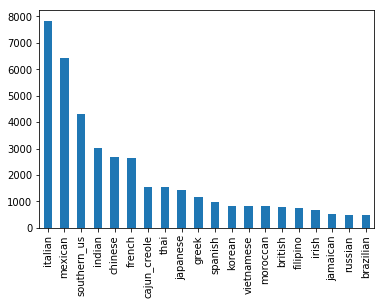

In [9]:
df['cuisine'].value_counts().plot("bar")

Dal grafico possiamo notare che le classi sono sbilanciate, cioè sono presenti molte ricette che vengono identificate come cucina italiana e messicana, mentre ci sono poche ricette russe e brasiliane.

In [10]:
###################################BILANCIAMENTO???????################################################

Per analizzare gli ingredienti, per adesso usiamo un approccio iterativo. Si crea un set di ingredienti in modo da eliminare eventuali duplicati.

In [11]:
ingredients = set()
for recipe in df['ingredients']:
    for i in recipe:
        ingredients.add(i)

In [12]:
len(ingredients)

6714

In totale notiamo che in tutto ci sono 6714 ingredienti diversi nel dataset.

Visualizziamo quelli più usati. Per fare questo gli ingredienti vanno inseriti in una lista in modo da mantenere i duplicati che poi dovranno essere contati.

In [13]:
ingredients_list = list()
for i in df['ingredients']:
    for word in i:
        ingredients_list.append(word)

In [14]:
common_ingredients = pd.Series(ingredients_list)
common_ingredients.value_counts().nlargest(15)

salt                   18049
onions                  7972
olive oil               7972
water                   7457
garlic                  7380
sugar                   6434
garlic cloves           6237
butter                  4848
ground black pepper     4785
all-purpose flour       4632
pepper                  4438
vegetable oil           4385
eggs                    3388
soy sauce               3296
kosher salt             3113
dtype: int64

Questi sono gli ingredienti più comuni

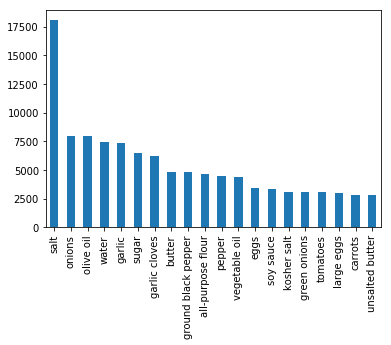

In [15]:
common_ingredients.value_counts().nlargest(20).plot(kind="bar")

Visualizziamo ora gli ingredienti più comuni per ogni cucina. Si crea un dizionario che contiene per ogni cucina un dizionario ingrediente -> numero di occorrenze e lo si ordina per tale conteggio. Possiamo poi costruire un DataFrame per visualizzare efficacemente quali sono gli ingredienti più usati.

In [16]:
tmp = df.groupby('cuisine')['ingredients'].apply(list)

def most_common_ingr_by_cuisine(cuisine):
    lists = tmp[cuisine]
    res = defaultdict(int)
    for recipe in lists:
        for ingr in recipe:
            res[ingr] += 1
    return sorted(res.items(), key=lambda x: x[1], reverse=True)

Chiamando la funzione qui sopra passando, ad esempio, la classe "italian" possiamo vedere che sale, olio di oliva, aglio e parmigiano sono alcuni degli ingredienti più comuni della cucina italiana.

In [17]:
commons_ital = pd.DataFrame(most_common_ingr_by_cuisine('italian'), columns=["ingredient", "count"]).head(10)
commons_ital

,ingredient,count
0,salt,3454
1,olive oil,3111
2,garlic cloves,1619
3,grated parmesan cheese,1580
4,garlic,1471
5,ground black pepper,1444
6,extra-virgin olive oil,1362
7,onions,1240
8,water,1052
9,butter,1030


In realtà il sale è l'ingrediente più comune per molte cucine.

In [18]:
pd.DataFrame(most_common_ingr_by_cuisine('french'), columns=["ingredient", "count"]).head(3)

,ingredient,count
0,salt,1203
1,sugar,637
2,all-purpose flour,593


In [19]:
pd.DataFrame(most_common_ingr_by_cuisine('brazilian'), columns=["ingredient", "count"]).head(3)

,ingredient,count
0,salt,194
1,onions,133
2,olive oil,118


Definiamo ora una funzione che restituisca il numero di ingredienti medio per ogni ricetta di una determinata cucina.

In [20]:
def avg_ingr_per_recipe(cuisine):
    recipes = tmp[cuisine]
    count = 0;
    for recipe in recipes:
        for ingr in recipe:
            count += 1;
    return count/len(recipes)

avg_ingr_per_recipe('brazilian')

9.5203426124197

In [21]:
average = {cuisine: avg_ingr_per_recipe(cuisine) for cuisine in df['cuisine'].unique()}
average

{'greek': 10.182127659574467,
 'southern_us': 9.634953703703705,
 'filipino': 10.0,
 'indian': 12.705960705960706,
 'jamaican': 12.214828897338403,
 'spanish': 10.42366026289181,
 'italian': 9.909032916560347,
 'mexican': 10.87744641192917,
 'chinese': 11.98279087167976,
 'british': 9.708955223880597,
 'thai': 12.545808966861598,
 'vietnamese': 12.675151515151516,
 'cajun_creole': 12.617076326002588,
 'brazilian': 9.5203426124197,
 'french': 9.817838246409675,
 'japanese': 9.735066760365426,
 'irish': 9.299850074962519,
 'korean': 11.28433734939759,
 'moroccan': 12.909866017052375,
 'russian': 10.224948875255624}

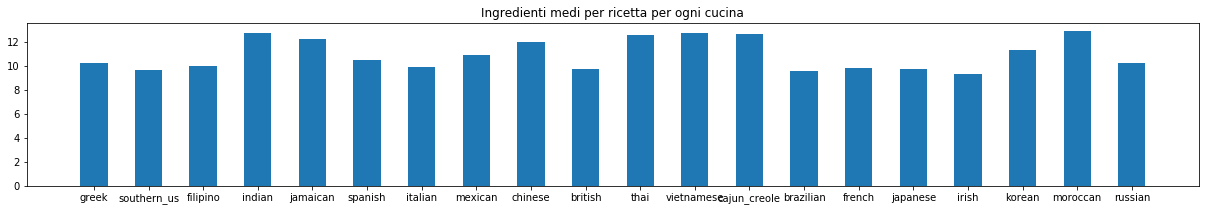

In [22]:
plt.figure(figsize=(21, 3))
plt.bar(average.keys(), average.values(), align="center", width=0.5)
plt.title("Ingredienti medi per ricetta per ogni cucina")
plt.show()

# Preprocessing dei dati

In questa fase, partendo dai risultati dell'analisi, effettuiamo una trasformazione dei dati in modo che siano pronti per essere elaborati dagli algoritmi di learning.

Come abbiamo potuto notare, il dataframe si compone di righe formate da:

- **[cuisine]**: categoria di cucina
- **[ingredients]**: lista di ingredienti in formato testuale

In [24]:
# NON HO CAPITO MOLTO LA PARTE QUI SOTTO V

Come possiamo gestire gli ingredienti di una ricetta?

 - Considerandoli cosi come sono posti, cioè "black olives" rimane "black olives"
 - Unirli in un unica stringa e applicare tecniche di text processing per cercare di estrarre più informazioni
   - Stemming, Lemming, Bag of Word, Vector Space Model (Tfidf)

In [25]:
# ECCO QUESTA ^

## Binarizzazione

Un primo approccio naive sarebbe quello di estrarre dal dataset un set contenente tutti gli ingredienti presenti e binarizzare ogni ricetta.
- Ad ogni riga, che rappresenta una ricetta, è associato un vettore di elementi in [0, 1] in cui la cella corrispondente all'ingrediente contiene 1 se è usato nella ricetta, 0 altrimenti.
- Avremmo ottenuto un dataset con circa 6700 features e 40'000 istanze, con un'alta occupazione di memoria e lunghi tempi di calcolo.

Oltre ad essere evidentemente un metodo poco scalabile, lento, e che occupa livelli veramente alti di memoria, lavora considerando troppi ingredienti e probabilmente è troppo complesso per essere efficace. In seguito ad alcuni test non riportati, si è effettivamente rivelato abbastanza inefficiente e inaccurato, motivo per cui sono stati subito scelti approcci differenti, previlegiando soluzioni con un numero di feature ridotto.

### Vector Space Model

Questo modello consente di rappresentare le ricette come vettori all'interno di un iperspazio in cui a ogni singola parola del dizionario comune (in questo caso, ogni singolo ingrediente) viene associato un peso che indica quanto esso contraddistingua la ricetta stessa.
Il modello tf-idf si adatta particolarmente bene allo scopo, in quanto:
- Associa ad ogni parola un peso che dipende sia dalla frequenza di uso locale Tf (cioè nella stessa ricetta) sia negli altri documenti idf (ricette)
- Tutti gli ingredienti vengono mappati
- I valori per ogni parola sono normalizzati in [0, 1]


Di default, un TfidfVectorizer() effettua del preprocessing prima di creare la matrice che contiene i pesi. Questo preprocessing può comprendere l'eliminazione di eventuali stopword (cioè parole inglesi di poca importanza nella comprensione dei contenuti che vengono scartate), segni di punteggiatura e tanto altro. Una possibile variante è quella di considerare le ricette sia divise per singole parole che per n-uple.

Per prima cosa, manipoliamo la colonna 'ingredients' del dataframe
- trasformiamo la lista di ingredienti in un'unica stringa in modo che possa essere letta dal tokenizer

In [ ]:
for idx in df.index:
    txt = ""
    for ing in df.loc[idx, "ingredients"]:
        txt += (ing + " ")
    df.loc[idx, "ingredients"] = txt

In [ ]:
df.head()

Creiamo i set per il training dei modelli e il calcolo dello score sul validation

In [ ]:
X_t, X_v, y_t, y_v = train_test_split(df['ingredients'], df['cuisine'], random_state=42, test_size=1/3)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Perceptron

Iniziamo lo studio dei modelli di classificazione dal più semplice, il Perceptron

In [ ]:
perceptron = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("perc", Perceptron())
])

Per ottimizzare i parametri, usiamo la Grid Search
 - Testiamo anche quale ngram ottimizza lo score

In [ ]:
grid1 = {
    'tfidf__ngram_range':[(1, 1), (1, 2), (1, 3), (1, 4)],  #considerzaioni di unigrammi, bigrammi, ...
    'perc__penalty': ['l1', 'l2'] #regolarizzazioni da effettuare
}
gs_perc = GridSearchCV(perceptron, param_grid=grid, n_jobs=-1)

In [ ]:
gs_perc.fit(X_t, y_t)

In [ ]:
gs_perc.score(X_v, y_v)